# **COURSEWORK:Kuzushiji - MNIST Classification**

**Author Name:** Benita Ashley



**Student Id:** 220058151

We begin with importing all the necessary libraries and packages that will be required for this classification problem.
We switch the runtime to GPU instead of using the CPU so that the training time is reduced.

In [1]:
import my_utils as mu
import torch
from torch import nn
import math
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
from IPython import display

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("cpu")

Using GPU


#**Read the dataset and create data loaders**

In [2]:
#Importing required libraries and packages
import torchvision
from torchvision import datasets, transforms

#Downloading test and training data from the torchvision library's datasets package
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
kmnist_trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
kmnist_testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



Using the DataLoader function from the torch library's utils package to convert the train and test data sets into dataloaders.Our dataset is made iterable by doing this. Making our dataset iterable will make it easier to separate the samples from the labels while training our neural network. When we set the batch size to 128, we extract our data in groups of 128 photos.

In [3]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(dataset=kmnist_trainset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(dataset=kmnist_testset, batch_size=batch_size, shuffle=False)

Creating a label map that will show each of the 10 labels that we plan to use to group our photographs. In order to acquire a general perspective of the dataset, we also print a random set of 30 labels and images from our train dataset.

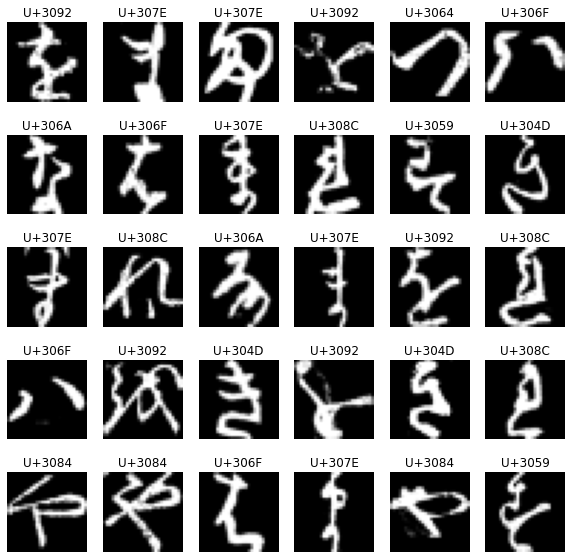

In [4]:
import matplotlib.pyplot as plt

#creating labels for the 10 classes 
labels_map={
    0: 'U+304A',
    1: 'U+304D',
    2: 'U+3059',
    3: 'U+3064',
    4: 'U+306A',
    5: 'U+306F',
    6: 'U+307E',
    7: 'U+3084',
    8: 'U+308C',
    9: 'U+3092',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 6,5

for j in range (1, cols*rows + 1):
    sample = torch.randint(len(kmnist_trainset), size = (1,)).item()
    image, label = kmnist_trainset[sample]
    figure.add_subplot(rows, cols, j)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [5]:
X, y = next(iter(train_iter)) # Getting the first batch to visualize the image and then dividing into patches

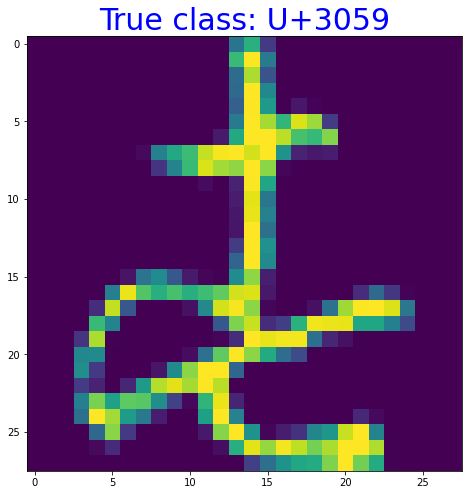

In [6]:
# Display the first image, and remove the channel dimension
x = X[0]
x = x.squeeze(dim=0)

# Get the true class of the first image
label = y.numpy()[0]
classes = ["U+304A","U+304D","U+3059","U+3064","U+306A","U+306F","U+307E","U+3084","U+308C","U+3092"]

# Plot the image
fig1 = plt.figure(figsize=(8,8));
fig1.tight_layout()
plt.title(f"True class: {classes[int(label)]}", fontsize = 30, color='blue')
plt.imshow(x.numpy())
plt.show()

We use the unfold functionality in Pytorch to create patches before sending it to the Neural Network. We create 49 patches of the above image from our dataset which can be any of the 10 classes as the shuffle was set to True while downloading the data. The patch has a width and height of 4 (total 16 pixels) which means that 49 patches are created for the 28x28 image.

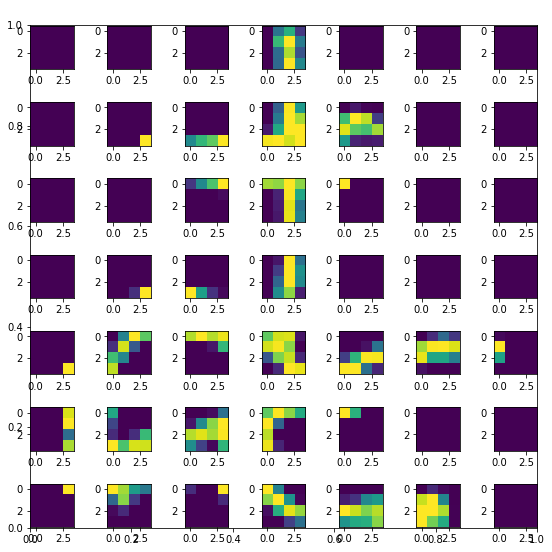

In [7]:
input_image = X[0] # first image 

patch_width = 4 # setting the patch width


patch_number = (28 // patch_width) ** 2 # computing the number of patches
 
# Converting the image into patches
patches = input_image.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
patch = patches[0].reshape([-1, 4, 4])

# Plot the 4 patches
fig = plt.figure(figsize=(8,8));
plt.title(f"True class: {classes[int(label)]}", fontsize = 15, color='w')
columns = 28//patch_width;
rows = 28//patch_width;
for i in range(len(patch)):
    fig.add_subplot(rows, columns, i+1)
    fig.tight_layout()
    plt.imshow(patch[i].numpy())
plt.show()

#**MODEL CREATION**

The patchify function takes input images and patch size as input parameters and returns the image patches after vectorizing each image. We have taken patch size as 4 so the function gives a tensor which has 49 patches for our 28x28 sized image.

In [8]:
def patch(input_images, patch_width):

  # Get the number of patches an image will contain
  patch_number = (28 // patch_width) ** 2
  # Convert the image into patches
  patches = input_images.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
  # Vectorize patches
  patches = patches.reshape([input_images.size(dim=0), patch_number, patch_width**2])
  return patches.to(device)

#**1.STEM**

In [9]:
class STEM(torch.nn.Module):
    def __init__(self, input_size,hidden_layer1_size,patch_size):
        super(STEM, self).__init__()
        self.patch_size = patch_size
        # Stem 
        self.StemLinear = nn.Linear(input_size,hidden_layer1_size) #(16,256) # Stem layer Output --> (49,256)
        self.batchnorm = nn.BatchNorm1d(49) # number of patches 

    def forward(self, x):
        # STEM
        x = x.squeeze(dim=1)
        # Convert images into vectorized patches
        x = patch(x, self.patch_size) # the input (16,49) is transposed to (49,16) in the patch function
        # Stem Linear Layer
        x = self.StemLinear(x)
        x = self.batchnorm(x)
        return x

#**2.BACKBONE**

In [10]:
class Backbone(torch.nn.Module):
    def __init__(self, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size):
        super(Backbone, self).__init__()
       
        # Backbone with 2 Blocks which contains 2 MLP's with 2 layers each

        # 1st Block
        self.Block1_Linear1 = nn.Linear(49, hidden_layer2_size)                     #(49 ,512)
        self.Block1_Linear2 = nn.Linear(hidden_layer2_size,hidden_layer1_size)      #(512,256)
        self.Block1_Linear3 = nn.Linear(hidden_layer1_size, hidden_layer3_size)     #(256,128)
        self.Block1_Linear4 = nn.Linear(hidden_layer3_size, hidden_layer4_size)     #(128, 64)
        self.batchnorm1 = nn.BatchNorm1d(hidden_layer1_size)                        #(256)
        self.Block1_ReLU = nn.ReLU()
        self.Block1_Dropout = nn.Dropout(0.1)

        # 2nd Block
        self.Block2_Linear1 = nn.Linear(hidden_layer1_size, hidden_layer4_size)      #(256,64) 
        self.Block2_Linear2 = nn.Linear(hidden_layer4_size, hidden_layer3_size)      #(64,128)
        self.Block2_Linear3 = nn.Linear(hidden_layer4_size, hidden_layer5_size)      #(64, 32) 
        self.Block2_Linear4 = nn.Linear(hidden_layer5_size, hidden_layer6_size)      #(32, 16)  
        self.batchnorm2 = nn.BatchNorm1d(hidden_layer3_size)                         #(128)
        self.Block2_ReLU = nn.ReLU()
        self.Block2_Dropout = nn.Dropout(0.2)

    def forward(self, x):

        # 1st Block 
        # MLP 1
        x = torch.transpose(x,1,2)   
        x = self.Block1_Linear1(x)
        x = self.Block1_ReLU(x)
        x = self.Block1_Dropout(x)
        x = self.Block1_Linear2(x)
      
        # MLP 2
        x = torch.transpose(x,1,2) 
        x = self.Block1_Linear3(x)
        x = self.Block1_ReLU(x)
        x = self.Block1_Dropout(x)
        x = self.Block1_Linear4(x)
        x = self.batchnorm1(x)

        # 2nd Block 
        x = torch.transpose(x,1,2)

        # MLP 1
        x = self.Block2_Linear1(x)
        x = self.Block2_ReLU(x)
        x = self.Block2_Dropout(x)
        x= self.Block2_Linear2(x)

        # MLP 2
        x = torch.transpose(x,1,2)
        x = self.Block2_Linear3(x)
        x = self.Block2_ReLU(x)
        x = self.Block2_Dropout(x)
        x= self.Block2_Linear4(x)
        x = self.batchnorm2(x)

        return x

#**3.CLASSIFIER**

In [11]:
class Classifier(torch.nn.Module):
    def __init__(self, hidden_layer6_size, num_of_classes):
        super(Classifier, self).__init__()
        # Classifier
        self.ClassifierLinear = nn.Linear(hidden_layer6_size, num_of_classes)        #(16,10)
    def forward(self, x):
        # Get the average patch feature vector for the image
        x = torch.mean(x, 1)
        # Final Linear layer of shape (16,10)
        out = self.ClassifierLinear(x)
        return out

#**4. NEURAL NETWORK MODEL**

In [12]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, patch_size, input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size, num_of_classes):
        super(NeuralNetwork, self).__init__()

        self.patch_size = patch_size
        self.input_size = input_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.hidden_layer4_size = hidden_layer4_size
        self.hidden_layer5_size = hidden_layer5_size
        self.hidden_layer6_size = hidden_layer6_size
        self.num_of_classes = num_of_classes

        self.Stem = STEM(input_size,hidden_layer1_size,patch_size)
        self.backbone = Backbone(hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size)
        self.classifier = Classifier(hidden_layer6_size, num_of_classes)

    def forward(self, x):
      x = self.Stem(x)
      x = self.backbone(x)
      x = self.classifier(x)
      return x

In [13]:
patch_size = 4
input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size, num_of_classes = patch_size**2, 256, 512, 128, 64, 32, 16, 10 
newnet = NeuralNetwork(patch_size, input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size, hidden_layer5_size, hidden_layer6_size, num_of_classes).to(device)
print(newnet) #prints the model structure

NeuralNetwork(
  (Stem): STEM(
    (StemLinear): Linear(in_features=16, out_features=256, bias=True)
    (batchnorm): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (backbone): Backbone(
    (Block1_Linear1): Linear(in_features=49, out_features=512, bias=True)
    (Block1_Linear2): Linear(in_features=512, out_features=256, bias=True)
    (Block1_Linear3): Linear(in_features=256, out_features=128, bias=True)
    (Block1_Linear4): Linear(in_features=128, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Block1_ReLU): ReLU()
    (Block1_Dropout): Dropout(p=0.1, inplace=False)
    (Block2_Linear1): Linear(in_features=256, out_features=64, bias=True)
    (Block2_Linear2): Linear(in_features=64, out_features=128, bias=True)
    (Block2_Linear3): Linear(in_features=64, out_features=32, bias=True)
    (Block2_Linear4): Linear(in_features=32, out_features=16, bias=True)
    (

#**Initialise weights**

The kaiminguniform initialization function is used to assign weights to the model.

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear): 
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')


newnet.apply(init_weights);

#**Loss Function and Optimizer**

We've used the Cross Entropy Loss as the loss function and we've used the Adam Optimizer in the Optimiser function with learning rate of 0.001

In [15]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(newnet.parameters(),betas=(0.9, 0.999),lr = 0.001, weight_decay = 0.0005)

#**Adding a scheduler**

We've added a scheduler to adjust the learning rate whenever the loss curve becomes flat. Our model will fit the data better and be more accurate as a result of the variable learning rate. The training function, which the scheduler monitors, calculates model loss. Patience is set to 20, which means that we will ignore the first 21 epochs with no improvement and it will decrease the learning rate after the 16th epoch to improve the model accuracy.

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 15, threshold = 1e-8)

#**Function to calculate accuracy, evaluation accuracy and accumulator**

In [17]:
def accuracy(y_hat, y):  #2nd dimension stores prediction scores for each class is in matric y_hat
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)        
    compute = (y_hat.type(y.dtype) == y) 
    return float(torch.sum(compute)) # Taking the sum yields the number of correct predictions

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [18]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [19]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # Number of correct predictions, number of predictions
    for _, (X, y) in enumerate(data_iter):
        X = X.to(device)  # transferring tensors to GPU
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [20]:
evaluate_accuracy(newnet, test_iter)

0.0977

#**Functions to train the model and plot the loss accuracy curve**

In [21]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=128, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X = X.to(device)  # transferring our tensors to GPU
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [22]:

class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [23]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    valid_loss = 0
    max_acc = 0
    max_acc_iter = 0
    
    newnet.eval()
    for data, label in test_iter:
      data = data.to(device)  # transferring our tensors to GPU
      label = label.to(device)
      target = newnet(data)
      valid_step_loss = loss(target, label)
      valid_loss += valid_step_loss.item() * data.size(0)

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'The training loss is {train_metrics[0]}')
        print(f'The training accuracy is {train_metrics[1]*100}%')
        print(f'The test accuracy for epoch number {epoch+1} is {test_acc*100}%')

        if test_acc > max_acc:
          max_acc = test_acc
          max_acc_iter = epoch+1
        print(f'The Maximum test accuracy is {max_acc*100}% achieved at epoch number {max_acc_iter}')
        animator.add(epoch + 1, train_metrics + (test_acc,))

        # adding a scheduler to adjust learning rates while training
        if scheduler:
          scheduler.step(valid_loss/len(test_iter))

        else:
          for param_group in optimizer.param_groups:
            param_group['lr']= scheduler(epoch)

    train_loss, train_acc = train_metrics
    print(f'The final test accuracy is: {test_acc*100}%')
    print(f'The final training loss is: {train_metrics[0]}')
    print(f'The final training accuracy is: {train_metrics[1]*100}%')
    print(f'The Maximum test accuracy is {max_acc*100}% achieved at epoch number: {max_acc_iter}')

#**Training the model and plotting the loss accuracy curves**

The neural network was trained over a period of 20 epochs. We need fewer training epochs because we are utilising batch normalisation, which is known to accelerate gradient convergence. We also used alternative epoch sizes with varying learning rates, such as 30, 50, and 100, however after training for more than 20 epochs, the accuracy and loss remained constant.

The final test accuracy is: 93.02%
The final training loss is: 0.01187077654004097
The final training accuracy is: 99.87666666666667%
The Maximum test accuracy is 93.13% achieved at epoch number: 19


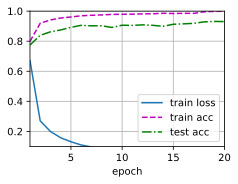

In [24]:
import my_utils as mu
num_epochs = 20
train_ch3(newnet, train_iter, test_iter, loss, num_epochs, optimizer, scheduler)

#References
[1] TensorFlow. 2022. tf.keras.callbacks.ReduceLROnPlateau  |  TensorFlow Core v2.9.1. [online] Available at: <https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau> 

[2] Pytorch.org. 2022. Unfold — PyTorch 1.12 documentation. [online] Available at: <https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html>

[3] <https://www.simonwenkel.com/notes/ai/datasets/vision/Kuzushiji-MNIST.html>

[4] https://doi.org/10.48550/arXiv.2110.00929

[5] Coursework resources : lecture slides, reference books, lab materials